In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.cross_decomposition import PLSRegression
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline
from msresist.parameter_tuning import MSclusPLSR_tuning
from msresist.plsr import Q2Y_across_components, R2Y_across_components
from msresist.figures.figure2 import plotR2YQ2Y, plotMixedClusteringPLSR_GridSearch, plotMeasuredVsPredicted, plotScoresLoadings, plotclusteraverages
from msresist.clustering import MassSpecClustering
from msresist.sequence_analysis import preprocess_seqs, FormatName, pYmotifs
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from msresist.pre_processing import preprocessing, MergeDfbyMean, LinearFoldChange, FoldChangeToControl, MapOverlappingPeptides, BuildMatrix, TripsMeanAndStd, CorrCoefFilter
from msresist.FileExporter import create_download_link
import warnings
warnings.simplefilter("ignore")

In [2]:
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000)

## Re-implementation with AXL mutants

### Phosphorylation measurements:

#### + Erlotinib + AXL-activating Antibody (AF154)

In [3]:
X = preprocessing(Axlmuts_ErlF154=True, motifs=True, Vfilter=True, FCfilter=True, log2T=True, mc_row=True)
X = preprocess_seqs(X, "Y").sort_values(by="Protein")
X.columns = list(X.columns[:7]) + ["PC9", "Knock-Out", "Kin. Dead", "Knock-In", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]

treatments = ["PC9", "Knock-Out", "Kin. Dead", "Knock-In", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
# treatments = ["Knock-Out", "Kin. Dead", "Knock-In", "Y634F", "Y643F", "Y698F", "Y726F", "Y750F ", "Y821F"]
X = X[list(X.columns[:7]) + treatments]

d = X.select_dtypes(include=['float64']).T
info = X.select_dtypes(include=['object'])

In [4]:
d.index

Index(['PC9', 'Knock-Out', 'Kin. Dead', 'Knock-In', 'Y634F', 'Y643F', 'Y698F',
       'Y726F', 'Y750F ', 'Y821F'],
      dtype='object')

### Phenotypes

#### Cell Viability of AXL mutant Cell Lines

In [5]:
cv1 = pd.read_csv("msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR1.csv").iloc[:, 1:]
cv1_ab = cv1.loc[:, cv1.columns.str.contains('-A/E')]
cv2 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR2.csv').iloc[:, 1:]
cv2_ab = cv2.loc[:, cv2.columns.str.contains('-A/E')]
cv3 = pd.read_csv('msresist/data/Phenotypic_data/AXLmutants/20200130-AXLmutantsPhase_MeanTRs_BR3.csv').iloc[:, 1:]
cv3_ab = cv3.loc[:, cv2.columns.str.contains('-A/E')]

for ii in range(0, cv2_ab.columns.size):
    cv1_ab.iloc[:, ii] /= cv1_ab.iloc[0, ii]
    cv2_ab.iloc[:, ii] /= cv2_ab.iloc[0, ii]
    cv3_ab.iloc[:, ii] /= cv3_ab.iloc[0, ii]

cv = pd.concat([cv1_ab, cv2_ab], axis=0)
cv.insert(0, "Elapsed",  cv1.iloc[:, 0])
cv =  MergeDfbyMean(cv, cv1_ab.columns, "Elapsed").reset_index()
v = cv[cv["Elapsed"] == 96].iloc[0, 1:]
v = v[["PC9-A/E", "AXL KO-A/E", "Kdead-A/E", "Kin-A/E", "M4-A/E", "M5-A/E", "M7-A/E", "M10-A/E", "M11-A/E", "M15-A/E"]]
# v = v[["AXL KO-A/E", "Kdead-A/E", "Kin-A/E", "M4-A/E", "M5-A/E", "M7-A/E", "M10-A/E", "M11-A/E", "M15-A/E"]]

v

PC9-A/E       8.655653
AXL KO-A/E    2.163386
Kdead-A/E     3.416684
Kin-A/E       5.605935
M4-A/E        4.832729
M5-A/E        4.590040
M7-A/E        6.569096
M10-A/E       6.502780
M11-A/E       6.448521
M15-A/E       4.177015
Name: 32, dtype: float64

# Co-clustering and PLSR model

## Cross-validation Strategy 1: By clusters

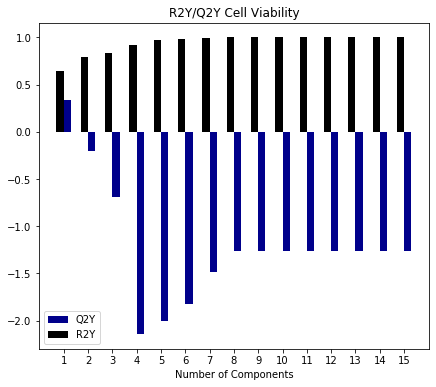

In [6]:
distance_method = "Binomial"
ncl = 15
GMMweight = 5

MSC = MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method).fit(d, v)
centers = MSC.transform(d)

fig, ax = plt.subplots(1, 1, figsize=(7,6))
plsr = PLSRegression(n_components=2)
plotR2YQ2Y(ax, plsr, centers, v, 1, ncl+1)

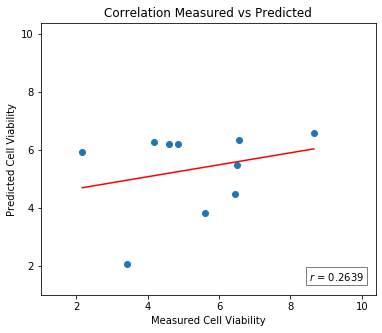

In [7]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
pls2 = PLSRegression(n_components=2)
plotMeasuredVsPredicted(ax, pls2, centers, v)

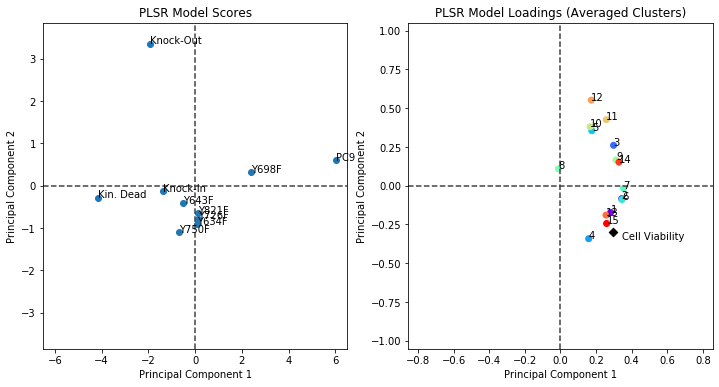

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
plotScoresLoadings(ax, pls2.fit(centers, v), centers, v, ncl, treatments, CV=1)

In [9]:
# MSC.clustermembers(X.T)

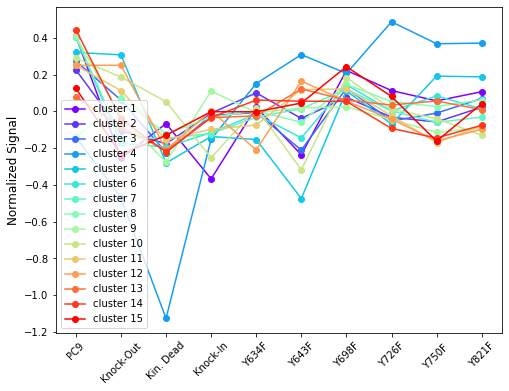

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, MSC.transform(d).T, treatments)

## Cross-validation Strategy 2: Across entire pipeline

In [ ]:
# scores = pd.DataFrame(scores)
# hp = scores.sort_values(by="mean_test_scores", ascending=False)
# hp.insert(0, "Ranking", list(np.arange(1, hp.shape[0]+1)))
# hp2 = scores[scores["#Components"]==2].sort_values(by="mean_test_scores", ascending=False)
# hp2.insert(0, "Ranking", list(np.arange(1, hp2.shape[0]+1)))

In [ ]:
# hp2.head()

In [ ]:
# create_download_link(hp, "20200227-GridSearch_AxlM_CellViab96h_NoPC9_Binomial_GMMiterLow.csv")

In [12]:
ncomp = 2

mixedCl_plsr = Pipeline([('mixedCl', MassSpecClustering(info, ncl, GMMweight=GMMweight, distance_method=distance_method)), ('plsr', PLSRegression(ncomp))])
fit = mixedCl_plsr.fit(d, v)
centers = mixedCl_plsr.named_steps.mixedCl.transform(d)

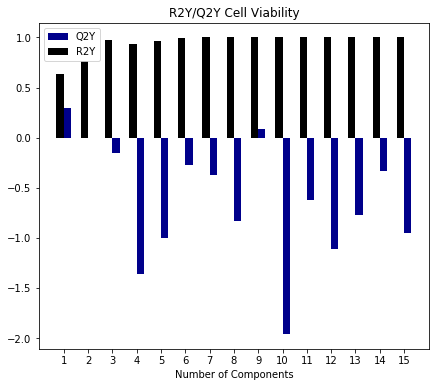

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))
plotR2YQ2Y(ax, mixedCl_plsr, d, v, cv=2, b=ncl+1)

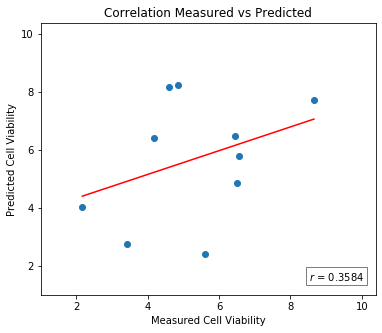

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
plotMeasuredVsPredicted(ax, mixedCl_plsr, d, v)

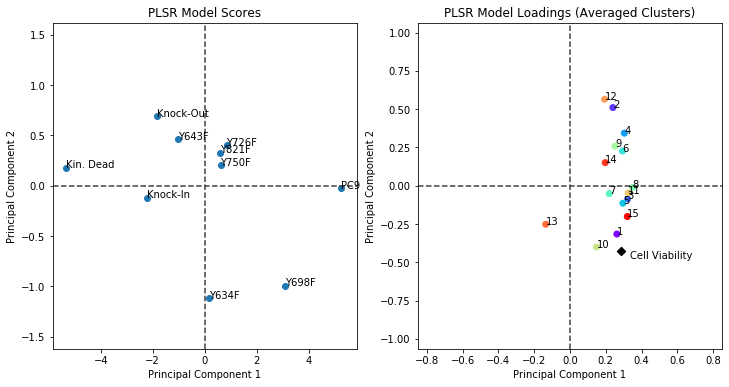

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

plotScoresLoadings(ax, fit, centers, v, ncl, treatments, CV=2)

In [16]:
clustermembers = mixedCl_plsr.named_steps.mixedCl.clustermembers(X.T)
create_download_link(clustermembers, "20200115-AXLaf154_BMP_W1/2.csv")

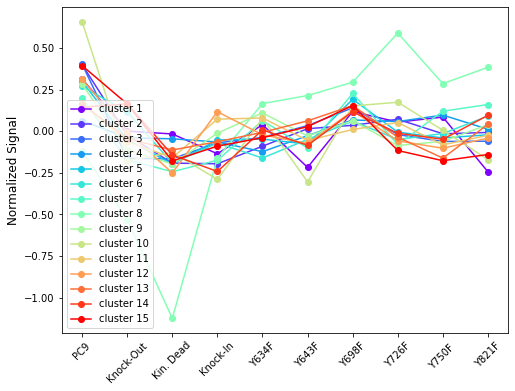

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plotclusteraverages(ax, centers.T, treatments)

In [18]:
clustermembers

,Prot_C1,abbv_C1,seqs_C1,UniprotAcc_C1,Pos_C1,r2/Std_C1,BioReps_C1,Prot_C2,abbv_C2,seqs_C2,UniprotAcc_C2,Pos_C2,r2/Std_C2,BioReps_C2,Prot_C3,abbv_C3,seqs_C3,UniprotAcc_C3,Pos_C3,r2/Std_C3,BioReps_C3,Prot_C4,abbv_C4,seqs_C4,UniprotAcc_C4,Pos_C4,r2/Std_C4,BioReps_C4,Prot_C5,abbv_C5,seqs_C5,UniprotAcc_C5,Pos_C5,r2/Std_C5,BioReps_C5,Prot_C6,abbv_C6,seqs_C6,UniprotAcc_C6,Pos_C6,r2/Std_C6,BioReps_C6,Prot_C7,abbv_C7,seqs_C7,UniprotAcc_C7,Pos_C7,r2/Std_C7,BioReps_C7,Prot_C8,abbv_C8,seqs_C8,UniprotAcc_C8,Pos_C8,r2/Std_C8,BioReps_C8,Prot_C9,abbv_C9,seqs_C9,UniprotAcc_C9,Pos_C9,r2/Std_C9,BioReps_C9,Prot_C10,abbv_C10,seqs_C10,UniprotAcc_C10,Pos_C10,r2/Std_C10,BioReps_C10,Prot_C11,abbv_C11,seqs_C11,UniprotAcc_C11,Pos_C11,r2/Std_C11,BioReps_C11,Prot_C12,abbv_C12,seqs_C12,UniprotAcc_C12,Pos_C12,r2/Std_C12,BioReps_C12,Prot_C13,abbv_C13,seqs_C13,UniprotAcc_C13,Pos_C13,r2/Std_C13,BioReps_C13,Prot_C14,abbv_C14,seqs_C14,UniprotAcc_C14,Pos_C14,r2/Std_C14,BioReps_C14,Prot_C15,abbv_C15,seqs_C15,UniprotAcc_C15,Pos_C15,r2/Std_C15,BioReps_C15
0,"Asparagine--tRNA ligase, cytoplasmic",NARS1,RDVCLyPRFVQ,O43776,Y539-p,N/A,1,Actin filament-associated protein 1-like 2,AFAP1L2,SSDEEyIYMNK,Q8N4X5,Y54-p,N/A,1,40S ribosomal protein SA,RPSA,LTEASyVNLPT,P08865,Y139-p,N/A,1,Actin-binding LIM protein 3,ABLIM3,ARsSSyADPWT,O94929,Y538-p,N/A,1,Annexin A1,ANXA1,DARALyEAGER,P04083,Y207-p,0.85,2,ARF GTPase-activating protein GIT1,GIT1,DDQHDyDSVAS,Q9Y2X7,Y383-p,N/A,1,Calponin-3,CNN3,KGMSVyGLGRQ,Q15417,Y261-p,N/A,1,Abl interactor 1,ABI1,TVPNDyMTSPA,Q8IZP0,Y213-p,N/A,1,Ephrin-B2,EFNB2,VFCPHyEKVSG,P52799,Y304-p,N/A,1,40S ribosomal protein S10,RPS10,NRIAIyELLFK,P46783,Y12-p,N/A,1,"Actin, cytoplasmic 1",ACTB,KEKLCyVALDF,P60709,Y218-p,N/A,1,Annexin A1,ANXA1,SAVSPyPTFNP,P04083,Y39-p,N/A,1,Filamin-A,FLNA,NLTETyVQDRG,P21333,Y1308-p,N/A,1,Adapter molecule crk,CRK,RVPNAyDKTAL,P46108,Y251-p,N/A,1,26S proteasome regulatory subunit 4,PSMC1,DKKKKyEPPVP,P62191,Y25-p,N/A,1
1,Brain-specific angiogenesis inhibitor 1-associated protein 2-like protein 1,BAIAP2L1,KDGWLyGEHDV,Q9UHR4,Y380-p,N/A,1,Actin filament-associated protein 1-like 2,AFAP1L2,SSDEEyIyMNK,Q8N4X5,Y54-p,N/A,1,ATPase WRNIP1,WRNIP1,AGEEHyNCISA,Q96S55,Y500-p,N/A,1,Annexin A2,ANXA2,GKsLYyYIQQD,P07355,Y317-p,N/A,1,Enhancer of filamentation 1,NEDD9,GHGYVyEYPSR,Q14511,Y166-p,N/A,1,Band 4.1-like protein 1,EPB41L1,IRPGEyEQFES,Q9H4G0,Y343-p,N/A,1,Elongation factor 1-alpha 1,EEF1A1,TGHLIyKCGGI,P68104,Y29-p,N/A,1,Abl interactor 2,ABI2,VVPNDyVPSPT,Q9NYB9,Y213-p,N/A,1,Epidermal growth factor receptor kinase substrate 8,EPS8,SSVSEyHPADG,Q12929,Y485-p,N/A,1,Desmoplakin,DSP,EKsAIyQLEEE,P15924,Y249-p,N/A,1,Alpha-actinin-1,ACTN1,PELIDyGKLRK,P12814,Y193-p,N/A,1,Focal adhesion kinase 1,PTK2,SETDDyAEIID,Q05397,Y397-p,0.51,2,Glycogen synthase kinase-3 alpha,GSK3A,EPNVSyICSRY,P49840,Y279-p,0.69,2,Annexin A5,ANXA5,RLYDAyELKHA,P08758,Y94-p,N/A,1,BAG family molecular chaperone regulator 3,BAG3,AQQGEyQTHQP,O95817,Y240-p,N/A,1
2,Calmodulin-1,CALM1,KDGNGyISAAE,P0DP23,Y100-p,N/A,1,"Arf-GAP with Rho-GAP domain, ANK repeat and PH domain-containing protein 1",ARAP1,FDDSDyDEVPE,Q96P48,Y231-p,N/A,1,Actin filament-associated protein 1-like 2,AFAP1L2,DEEYIyMNKVT,Q8N4X5,Y56-p,N/A,1,Breast cancer anti-estrogen resistance protein 1,BCAR1,YGQEVyDTPPM,P56945,Y267-p,N/A,1,Ezrin,EZR,PDFVFyAPRLR,P15311,Y270-p,N/A,1,GRB2-associated-binding protein 1,GAB1,VDSSLyNLPRS,Q13480,Y259-p,N/A,1,Focal adhesion kinase 1,PTK2,FGLSRyMEDST,Q05397,Y570-p,0.85,2,Catenin delta-1,CTNND1,FHPEPyGLEDD,O60716,Y280-p,N/A,1,Eukaryotic translation initiation factor 1b,EIF1B,IEHPEyGEVIQ,O60739,Y79-p,N/A,1,E3 ubiquitin-protein ligase CBL-B,CBLB,RtSQDyDQLPS,Q13191,Y889-p,N/A,1,Alpha-actinin-1,ACTN1,DVAEKyLDIPK,P12814,Y215-p,N/A,1,Kin of IRRE-like protein 1,KIRREL1,SRAVLyADYRA,Q96J84,Y622-p,N/A,1,Homeodomain-interacting protein kinase 1,HIPK1,AVCSTyLQSRY,Q86Z02,Y352-p,N/A,1,Brain-specific angiogenesis inhibitor 1-associated protein 2,BAIAP2,KLSDSySNTLP,Q9UQB8,Y337-p,N/A,1,Breast cancer anti-estrogen res